# Discretized Logistic Mixture distribution 

**Goal:** In this notebook you will work with TFP. First you plot the probability density function and the cumulative probability density function for the logistic distribution for diffrent location and scale parameters. Then you will discretize the logistic distribution which is continuous and can output any value, to be a discrete distribution and only output certain integer values. You will see how you can mix two logistic distributions and again discretize the resulting distribution. Finally you learn how to build a model with tensorflow and tfp to use the discretized logistic mixture distribution as output.


**Usage:** The idea of the notebook is that you try to understand the provided code by running it, checking the output and playing with it by slightly changing the code and rerunning it.  

**Content:**
* Work with the logistic distribution in TFP
* Discretize the logistic distribution
* Mix two logistic distribution to one distribution 
* Discretize the mixture of two logistic distributions 
* Define a model with Keras and TFP to use the discretized logistic mixture distribution as output


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_05/nb_ch05_03.ipynb)


In [0]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


#### Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_probability as tfp
%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0



### A single logistic distribution 
Let's start with the single logistic function and plot the probability density function and the cumulative probability density function. You maybe know this function more by it's cumulative probability distrubution which is used in case of logistic regression. You use the same location parameter for all three distributions and change the scale parameter, you can see that the density gets broader around the location which is 1, when you increase the scale parameter.

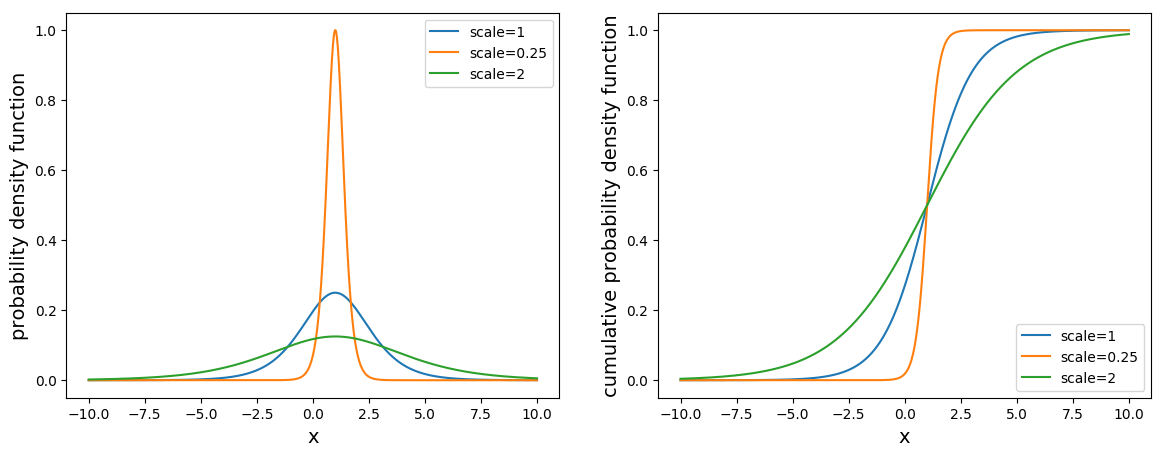

In [0]:
plt.figure(figsize=(14,5))

vals = np.linspace(-10,10,1000) 

plt.subplot(1,2,1)
dist1 = tfd.Logistic(loc=1, scale=1)
dist2 = tfd.Logistic(loc=1, scale=0.25)
dist3 = tfd.Logistic(loc=1, scale=2)

plt.plot(vals, dist1.prob(vals)) 
plt.plot(vals, dist2.prob(vals)) 
plt.plot(vals, dist3.prob(vals)) 
plt.legend(['scale=1', 'scale=0.25','scale=2'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)
plt.subplot(1,2,2)

plt.plot(vals, dist1.cdf(vals)) 
plt.plot(vals, dist2.cdf(vals)) 
plt.plot(vals, dist3.cdf(vals)) 
plt.legend(['scale=1', 'scale=0.25','scale=2'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.show()

If you sample form the distributions you can see that they can output any real value. Note that if you have a low scale parameter the values are closer around the location (in this case loc = 1).

In [0]:
print(dist1.sample(10))
print(dist2.sample(10))
print(dist3.sample(10))

tf.Tensor(
[-6.3053942e-01  7.1641260e-01  1.8696365e+00  1.3133540e+00
  5.3169501e-01  3.7380805e+00  7.7200294e-01  3.2237685e-01
  6.1094761e-05  2.0190358e-02], shape=(10,), dtype=float32)
tf.Tensor(
[0.55471253 0.8372476  1.3126332  0.9818163  0.12257272 1.2398187
 0.7666842  1.478456   1.5519972  1.0373051 ], shape=(10,), dtype=float32)
tf.Tensor(
[ -1.6326435    3.4983697   -2.6134822  -13.435865    -0.5484836
  -0.4933076    4.1837      -4.839446     0.01862931   0.44603896], shape=(10,), dtype=float32)


### Discretization of the logistic distribution

The QuantizedDistribution takes a probability distributions and creates a quantized version of it. From the documentation https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution we know:

1. Draw X (from distribution)
2. Set Y <-- ceiling(X)
3. If Y < low, reset Y <-- low
4. If Y > high, reset Y <-- high
5. Return Y

To create integer values which are capted between 0 and $2^{bits} - 1$, we can use the following code. The ceiling of x is just the next interger that is larger (or then x). For example: 

In [0]:
np.ceil(0.00001),np.ceil(0.6),np.ceil(0.999),np.ceil(1.0) #All return one

(1.0, 1.0, 1.0, 1.0)

In the next cell you can use the tfd.QuantizedDistribution for a discrete version of the logistic distribution with loc=1 and scale = 0.25, with the low and high parameters you can set the possible output values, in this case we use 0 as low and $2^4 -1 = 15$ as high. This means the output of the discrete distribution can take any integer form 0 to 15. You plot the probability density function and the cumulative probability density function. Here the "Inner distribution" is the logistic distribution and the "Quatized version" is as the names says the Quatized version of the inner distribution.

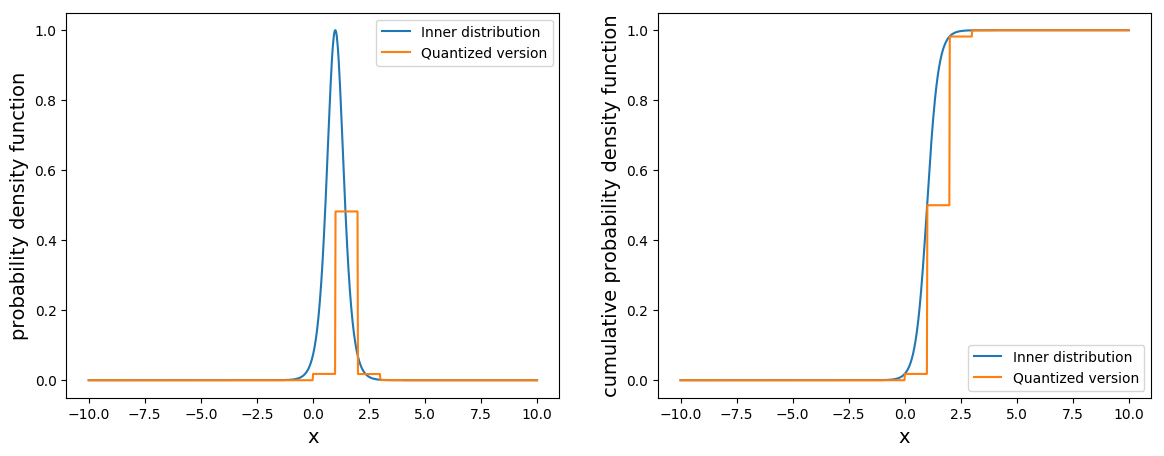

In [0]:
bits = 4
logi = tfd.Logistic(loc=1, scale=0.25)
discretized_logistic_dist = tfd.QuantizedDistribution(logi,low=0., high=2**bits - 1.)
vals = np.linspace(-10,10,1000) 

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(vals, logi.prob(vals)) 
plt.plot(vals, discretized_logistic_dist.prob(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, logi.cdf(vals)) 
plt.plot(vals, discretized_logistic_dist.cdf(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.show()

If you sample form the logistic function you can see the same as above, it can output any value, but if you sample from the quantized version of it you see that we only get integer values that can be from 0 to 15. Note that we can't have negativ values because the low parameter of the tfd.QuantizedDistribution function was set to 0.

In [0]:
print(logi.sample(10))
print(discretized_logistic_dist.sample(10))

tf.Tensor(
[ 0.95762074  1.3572706   1.3607295   0.8221738   0.90544844  0.37284678
  0.95226175  1.063959   -0.24354553  1.5205375 ], shape=(10,), dtype=float32)
tf.Tensor([1. 1. 2. 2. 1. 2. 1. 1. 1. 2.], shape=(10,), dtype=float32)


As you can see the peak of probability density function of the quatized version is not at the same position as the inner distribution. This is due to taking the ceil. Luckily, there is an easy workaround. You can just shift the distribution 0.5 to the left and then we have proper rounding.  
In next the cell you just shift the logistic distribution 0.5 to the left. You can do this with the tfd.TransformedDistribution function, you have to define which distribution you want to use and with the bijector=tfb.AffineScalar(shift=-0.5) argument you can shift the distribution. We again plot the probability density function and the cumulative probability density function for all three versions.

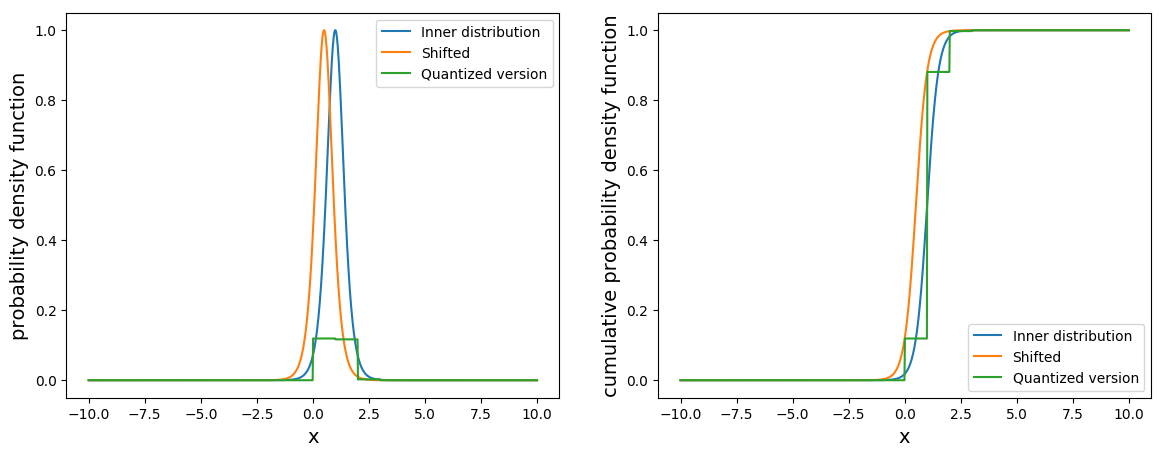

In [0]:
bits = 4

logi = tfd.Logistic(loc=1, scale=0.25)
logis = tfd.TransformedDistribution(distribution=tfd.Logistic(loc=1, scale=0.25),
                                    bijector=tfb.AffineScalar(shift=-0.5))
discretized_logistic_dist = tfd.QuantizedDistribution(logis,low=0.,high=2**bits - 1.)
    
vals = np.linspace(-10,10,1000) 


plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(vals, logi.prob(vals)) 
plt.plot(vals, logis.prob(vals)) 
plt.plot(vals, discretized_logistic_dist.prob(vals)) 
plt.legend(['Inner distribution','Shifted','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, logi.cdf(vals)) 
plt.plot(vals, logis.cdf(vals)) 
plt.plot(vals, discretized_logistic_dist.cdf(vals)) 
plt.legend(['Inner distribution','Shifted','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.show()


In [0]:
print(logis.sample(10))
print(discretized_logistic_dist.sample(10))

tf.Tensor(
[ 1.4992272  -0.7522907   0.62219214  0.22072804 -0.17724156  0.78147626
 -0.11199707  0.7947825   1.9229228   0.740399  ], shape=(10,), dtype=float32)
tf.Tensor([ 1.  1.  1.  1.  1.  1. -0.  3.  1.  1.], shape=(10,), dtype=float32)


To make it a bit simpler we can define the following function "quantize" which can be used for the quantisation.

In [0]:
def quantize(inner, low=0, bits=4):
    trans = tfd.TransformedDistribution(distribution=inner,bijector=tfb.AffineScalar(shift=-0.5))
    return tfd.QuantizedDistribution(trans,low=low,high=2**bits - 1.)

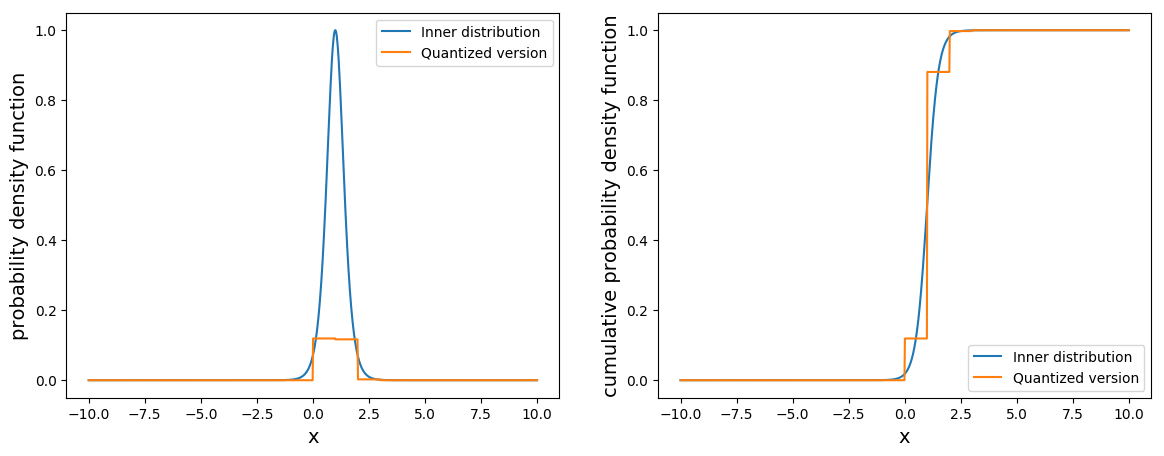

In [0]:
logi = tfd.Logistic(loc=1, scale=0.25)
discretized_logistic_dist = quantize(logi)

vals = np.linspace(-10,10,1000) 


plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(vals, logi.prob(vals)) 
plt.plot(vals, discretized_logistic_dist.prob(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, logi.cdf(vals)) 
plt.plot(vals, discretized_logistic_dist.cdf(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.show()


Now you can see the peak of probability density function of the quatized version is at same position as the inner distribution. And we have a nice discrete verson of the inner distribution.

### Mixture of logistic distributions and quantized version of the mixtures


Haveing the quantized distributions, we can now mix them to get even more flexible distributions. For this we use the "MixtureOfSameFamily" distribution. We will mix two logistic distributions with the locs = (4,10) and the scales = (0.25,05) and quantize them as before. Finally we have to use the "MixtureOfSameFamily" function to mix the two distributions and only get one output, we do the mixture by using a categorical distribution with 80% for the fist logistic distribution and 20% for the second logistic distribution. We again plot the probability density function and the cumulative probability density function for the mixture 



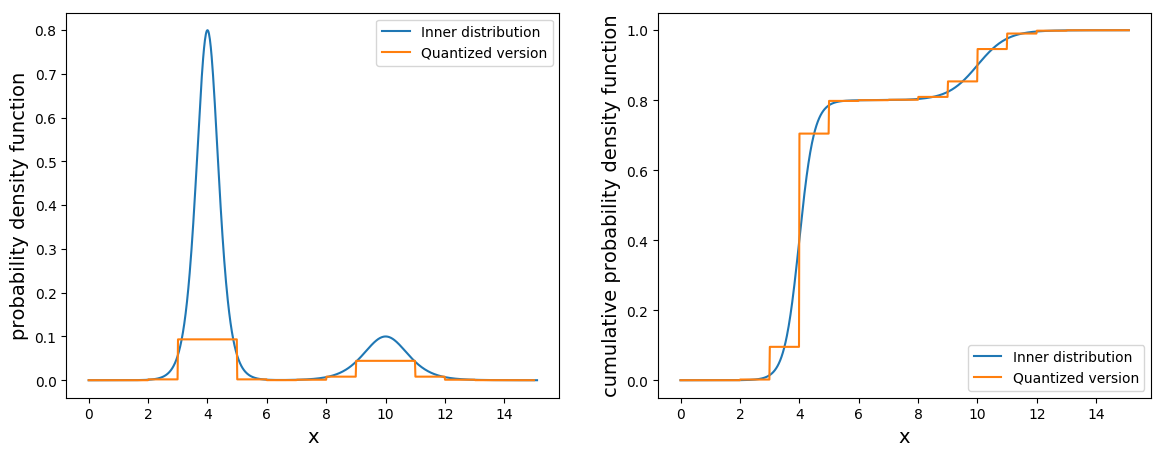

In [0]:
vals = np.linspace(0,15.1,1000) 

locs = (4.0,10.0) #A
scales = (0.25, 0.5) #B 
probs = (0.8, 0.2) #C 

dists = tfd.Logistic(loc=locs, scale=scales) #D
quant = quantize(dists, bits=4) #E
quant_mixture = tfd.MixtureSameFamily( #F
    mixture_distribution=tfd.Categorical(probs=probs),#G
    components_distribution=quant)
mixture = tfd.MixtureSameFamily( #C
    mixture_distribution=tfd.Categorical(probs=probs),#D
    components_distribution=dists)
#A centers of the two base distributions at 4 and 10
#B Spread of the two base distributions
#C Mixing 80% of the first (at 4.0) and 20% of the second
#D Two independent distributions (batch_shape = 2)
#E The quantized versions of the two independent distributions
#F A mixuture of both distributions 
#G The mixture is done with a Categorical Distribution with 80% and 20%

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(vals, mixture.prob(vals)) 
plt.plot(vals, quant_mixture.prob(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='upper right')
plt.xlabel('x',fontsize=14)
plt.ylabel('probability density function',fontsize=14)

plt.subplot(1,2,2)
plt.plot(vals, mixture.cdf(vals)) 
plt.plot(vals, quant_mixture.cdf(vals)) 
plt.legend(['Inner distribution','Quantized version'], loc='lower right')
plt.xlabel('x',fontsize=14)
plt.ylabel('cumulative probability density function',fontsize=14)
plt.show()



Here you can see that we have gone form two logistic distributions with continuous outcome to two logistic distributions with discrete outcome and then we mixed those distributions into one final distribution with one output with the MixtureSameFamily function.

In [0]:
print(dists.sample(10))
print(quant.sample(10))
print(mixture.sample(10))
print(quant_mixture.sample(10))

tf.Tensor(
[[ 4.118196   9.159763 ]
 [ 4.965525  11.704424 ]
 [ 5.0049524 10.309162 ]
 [ 4.2870116  9.9715185]
 [ 4.18754   11.845722 ]
 [ 3.6012084 10.210046 ]
 [ 4.487729  10.498993 ]
 [ 4.6834626  9.280884 ]
 [ 4.3393116 11.398417 ]
 [ 3.9567668 10.443842 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[ 4. 10.]
 [ 4. 10.]
 [ 4. 10.]
 [ 4.  9.]
 [ 4.  8.]
 [ 4. 10.]
 [ 4. 10.]
 [ 4. 11.]
 [ 4. 10.]
 [ 4. 11.]], shape=(10, 2), dtype=float32)
tf.Tensor(
[ 9.546567   3.9393096  4.3350153  3.9708116  3.7247496  4.9679627
  4.2765646 10.581856   4.239749   3.6708918], shape=(10,), dtype=float32)
tf.Tensor([ 5.  4.  3.  4.  5.  4. 11.  4.  4.  4.], shape=(10,), dtype=float32)


### Using the mixture of logistics in a neural netwok

In the next cell you see example code how to use the mixutre of logistics for a neural network.
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution


In [0]:
def quant_mixture_logistic(out, bits=8, num=3): 
    loc, un_scale, logits = tf.split(out,
                                     num_or_size_splits=num,
                                     axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
    distribution=tfd.TransformedDistribution(
        distribution=tfd.Logistic(loc=loc, scale=scale),
        bijector=tfb.AffineScalar(shift=-0.5)),
    low=0.,
    high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=logits), #logits will be normalized to one
        components_distribution=discretized_logistic_dist)
    return mixture_dist

Definition of the network

In [0]:
inputs = tf.keras.layers.Input(shape=(100,))  
h1 = Dense(10, activation='tanh')(inputs)
out = Dense(6)(h1)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)


model = Model(inputs=inputs, outputs=p_y)
#A A dense layer is used without activation. The transformation is done in zero_inf listing 5.l_zi 
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
_________________________________________________________________
distribution_lambda_7 (Distr ((None,), (None,))        0         
Total params: 1,076
Trainable params: 1,076
Non-trainable params: 0
_________________________________________________________________
